#### Lecture 10 - Optimization

C&C Problem 13.10-13.11. Find minimum of: $$ f(x) = 3 + 6x + 5x^2 + 3x^3 + 4x^4 $$ using:
- Bisection with initial bracket $x_l=-2$, $x_u=1$
- Newton's method with $x_0=1$
- Newton's method with finite difference estimates

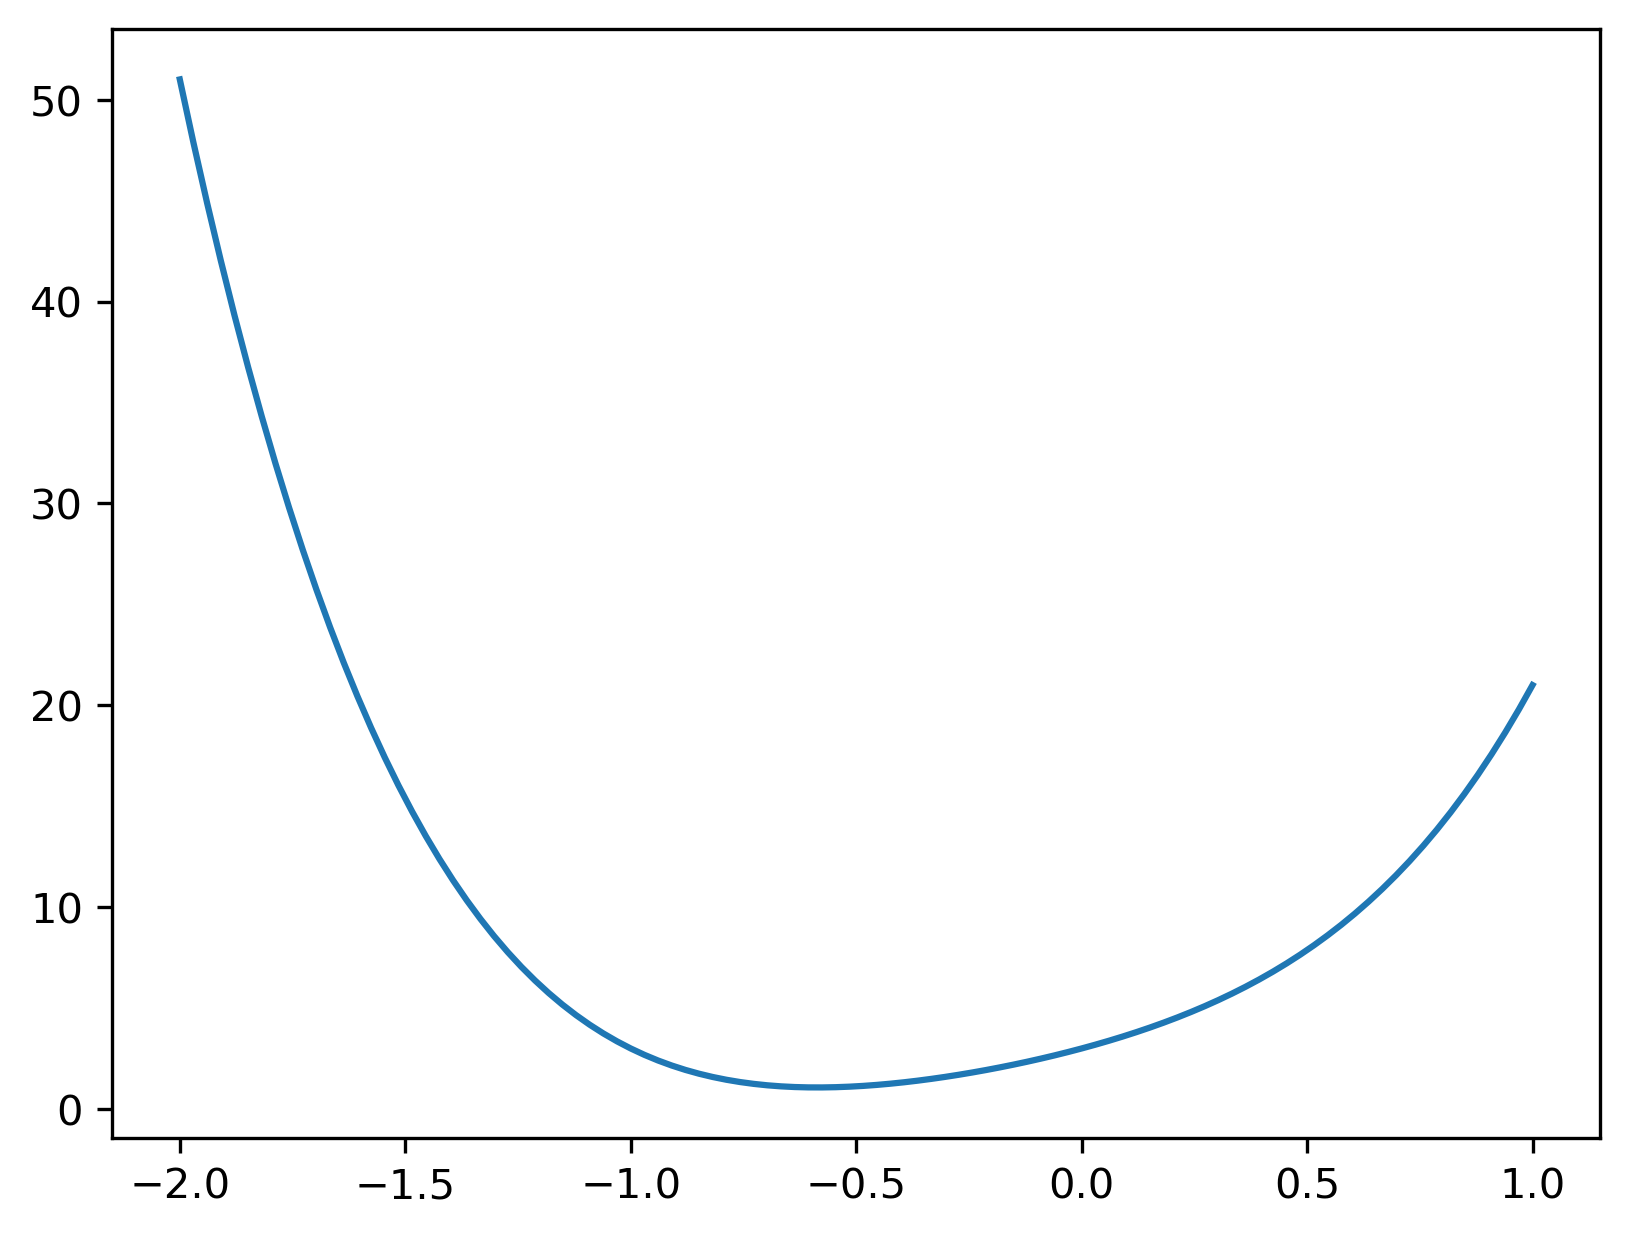

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

def f(x):
    return 3 + 6*x + 5*x**2 + 3*x**3 + 4*x**4

def fp(x):
    return 6 + 10*x + 9*x**2 + 16*x**3

def fpp(x):
    return 10 + 18*x + 48*x**2

x = np.linspace(-2,1,100)
plt.plot(x, f(x))
plt.show()

In the simplest case, we can just use our existing root finding methods to find the minimum, $f^\prime(x)=0$. For example bisection from L8, where `f` is renamed `fp` to reflect that we are optimizing instead of root finding.

In [2]:
def bisection(fp, xl, xu, tol=1e-8):
    
    # check for valid initial bracket
    assert fp(xl) * fp(xu) < 0, 'Choose xl,xu such that f(xl) * f(xu) < 0'
    err = 9999
    errors = [] # store errors to plot later
    
    while err > tol:
        xr = (xl + xu) / 2
        test = fp(xl) * fp(xr)
        if test < 0:
            xu = xr
        elif test > 0:
            xl = xr
        err = np.abs(fp(xr))
        errors.append(err)
    
    return xr, errors

xb, errors_b = bisection(fp, -2, 1)

print('Estimate of minimum: x=%0.4f, f(x)=%0.4f' % (xb, f(xb)))
print('Iterations: %d' % len(errors_b))

Estimate of minimum: x=-0.5867, f(x)=1.0690
Iterations: 31


Newton's method, modified for optimization by renaming `f` to `fp`, and `fp` to `fpp`. Note this function is only for the 1-dimensional case.

In [3]:
def newton(fp, fpp, x, tol=1e-8):

    err = 9999
    errors = [] # store errors to plot later
    
    while err > tol:
        x = x - fp(x)/fpp(x)
        err = np.abs(fp(x))
        errors.append(err)
    
    return x, errors

In [4]:
xn, errors_n = newton(fp, fpp, 1)

print('Estimate of minimum: x=%0.4f, f(x)=%0.4f' % (xn, f(xn)))
print('Iterations: %d' % len(errors_n))

Estimate of minimum: x=-0.5867, f(x)=1.0690
Iterations: 6


Newton's method converges faster than bisection.

In the last part of the problem, we substitute finite (centered) differences for the first and second derivatives in Newton's method. This is a similar idea to the Secant method for root finding. The difference formulas are defined with a step size proportional to the value of $x$, for example $\delta=0.01$ is a 1% change. Note these functions are not specific to this problem and will work for any $f(x)$.

In [5]:
def fp_cd(f, x, d=0.01): # f prime centered difference
    return (f(x + d*x) - f(x - d*x)) / (2*d*x)

def fpp_cd(f, x, d=0.01): # f double-prime centered difference
    return (f(x + d*x) - 2*f(x) + f(x - d*x)) / (d*x)**2

Test these against the analytical derivatives at $x=1$:

In [6]:
print('First derivative analytical: ', fp(1))
print('First derivative numerical: ', fp_cd(f,1))

First derivative analytical:  41
First derivative numerical:  41.00190000000019


In [7]:
print('Second derivative analytical: ', fpp(1))
print('Second derivative numerical: ', fpp_cd(f,1))

Second derivative analytical:  76
Second derivative numerical:  76.00079999996012


Now we can use them in Newton's method. Only `f` is required as input.

In [8]:
def newton_cd(f, x, tol=1e-8):

    err = 9999
    errors = [] # store errors to plot later
    
    while err > tol:
        x = x - fp_cd(f,x) / fpp_cd(f,x)
        err = np.abs(fp_cd(f,x))
        errors.append(err)
    
    return x, errors

xcd, errors_cd = newton_cd(f, 1)

print('Estimate of minimum: x=%0.4f, f(x)=%0.4f' % (xcd, f(xcd)))
print('Iterations: %d' % len(errors_cd))

Estimate of minimum: x=-0.5867, f(x)=1.0690
Iterations: 6


The iteration count is the same as the analytical Newton's method. However, note that each iteration of the finite difference version is performing more function evaluations to estimate the derivatives. It would be possible to make this more efficient by computing the `f(x +/- d*x)` terms only once and using them to calculate both `fp` and `fpp`.

#### Problem 16.20

Find location (2-dimensional) of peak pollutant concentration in a channel: 
$$ c(x,y) = 7.7 + 0.15x + 0.22y - 0.05x^2 - 0.016y^2 - 0.007xy $$

Over the domain: $-10 \leq x \leq 10$, $0 \leq y \leq 20$. Solve with:
- Gradient ascent with $\alpha=0.01$
- Newton's method
- `scipy.optimize.minimize`

In [9]:
def c(x,y):
    return 7.7 + 0.15*x + 0.22*y - 0.05*x**2 - 0.016*y**2 - 0.007*x*y

First look at the function using a filled contour plot. The `meshgrid` function creates the set of all 2D `(x,y)` points from the ranges of `x` and `y`. These are assigned to temporary variables because they are not used later in the optimization. Last, the concentration values come from calling `c(x,y)`. The `contourf` function has many options, see docs [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html).

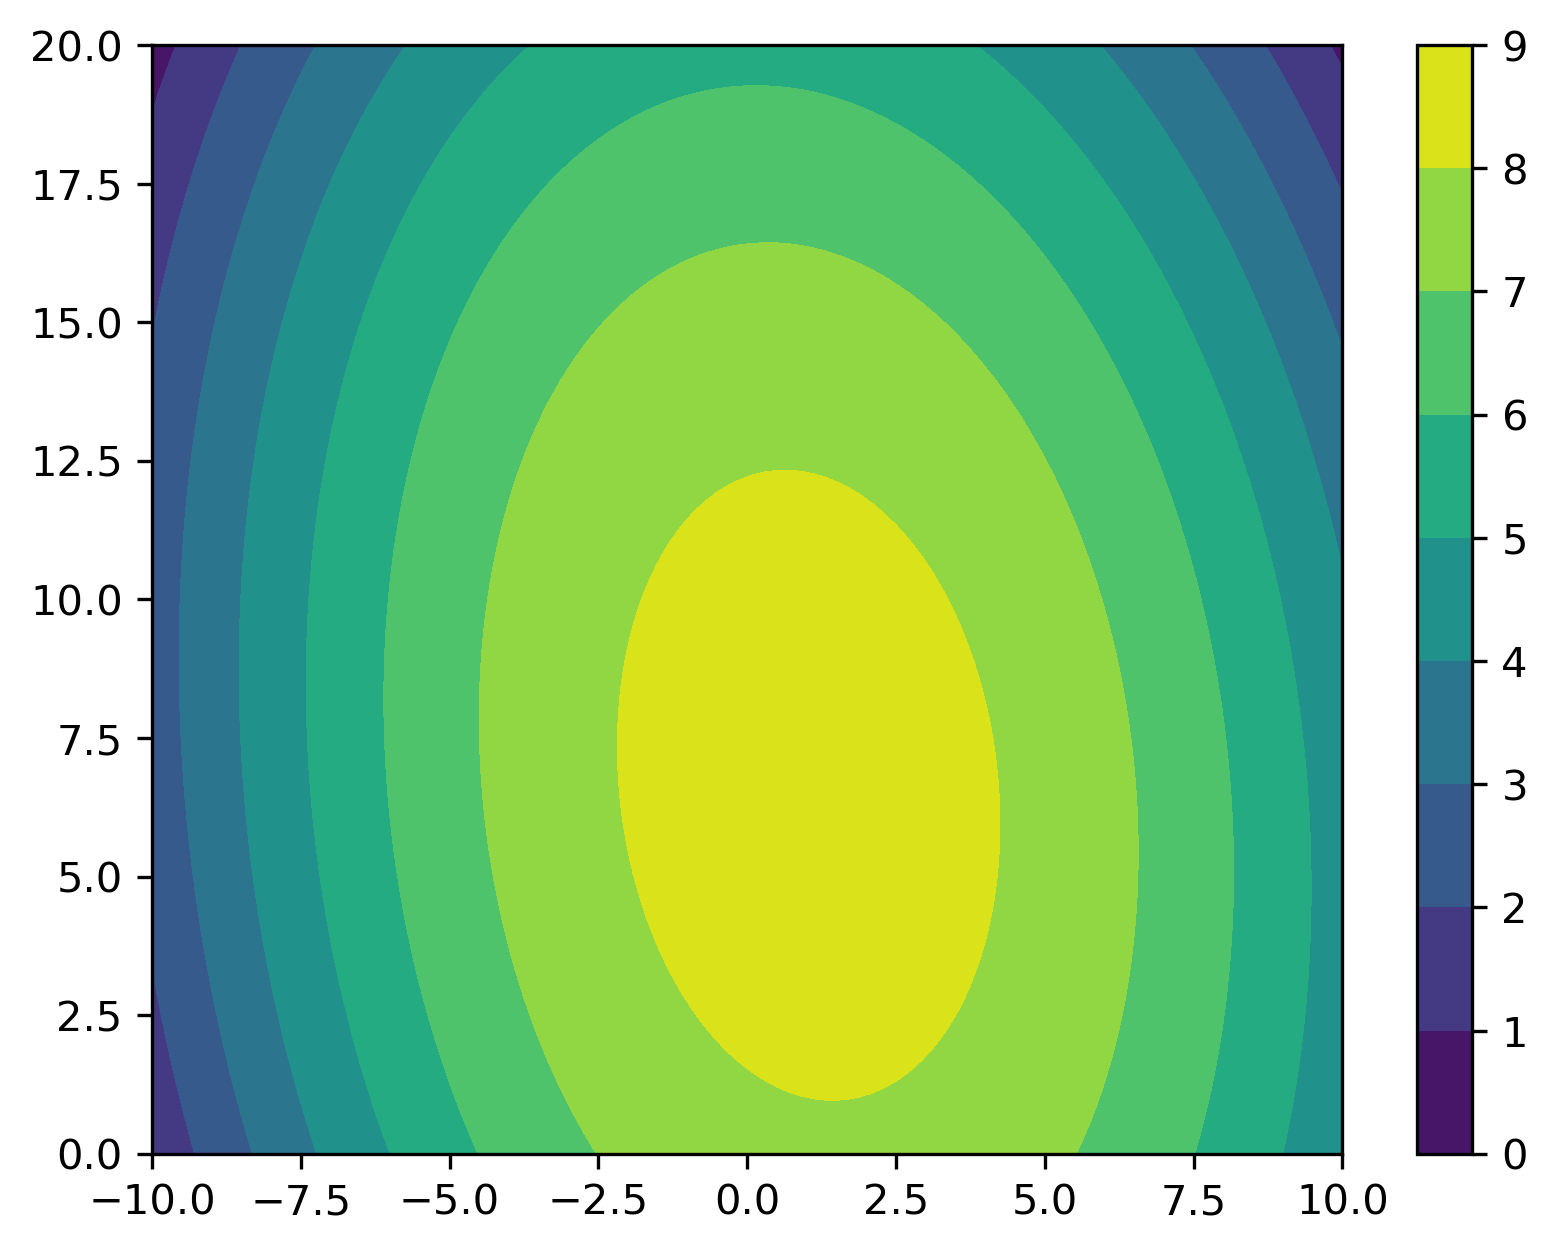

In [10]:
x_temp, y_temp = np.meshgrid(np.linspace(-10,10,100), np.linspace(0,20,100))
plt.contourf(x_temp, y_temp, c(x_temp, y_temp))
plt.colorbar()
plt.show()

Before we write gradient ascent, we will need the gradient function. This could also be defined using the numerical derivatives.

In [11]:
def c_grad(x,y):
    dfdx = 0.15 - 0.1*x - 0.007*y
    dfdy = 0.22 - 0.032*y - 0.007*x
    return np.array([dfdx, dfdy])

In [12]:
# use vector norm to measure error in gradient
from scipy.linalg import norm

def gradient_ascent(f_grad, x, y, alpha=0.01, tol=1e-8):
    err = 9999
    errors = []
    
    while err > tol:
        grad = f_grad(x,y)
        x = x + alpha * grad[0]
        y = y + alpha * grad[1]
        err = np.abs(norm(grad,2))
        errors.append(err)
    
    return x, y, errors

In [13]:
x, y, errors = gradient_ascent(c_grad, 5, 15)
print('Estimate of minimum: x=%0.4f, y=%0.4f, c(x,y)=%0.4f' % (x, y, c(x,y)))
print('Iterations: %d' % len(errors))

Estimate of minimum: x=1.0346, y=6.6487, c(x,y)=8.5089
Iterations: 54405


The initial point $(x_0,y_0)$ should not matter for this problem, because it looks concave. The local maximum will be the global maximum. Our function converges to what looks like a reasonable point, based on the contour plot. However, it takes quite a few iterations to get there. This is sensitive to the choice of $\alpha$. For example, $\alpha=10$ will converge in ~50 iterations instead.

Can we do better with Newton's method? First we have to define the Hessian for the two-dimensional problem. This is the analytical version, which we would probably not do for more complex problems. Instead finite differences or another approximation could be used. For this problem the function $c(x,y)$ is quadratic, the Hessian contains constant values.

In [14]:
def c_H(x,y):
    d2fdx2 = -0.1
    d2fdy2 = -0.032
    d2fdxdy = -0.007 # equal to d2fdydx
    return np.array([[d2fdx2, d2fdxdy], [d2fdxdy, d2fdy2]])

In [15]:
from scipy.linalg import inv # matrix inverse

def newton_multivariate(f_grad, f_H, x, y, tol=1e-8):
    err = 9999
    errors = []
    
    # group x,y into the same vector to do matrix math
    x = np.array([x,y])
    
    while err > tol:
        # our gradient function is still set up for separate x,y inputs
        grad = f_grad(x[0],x[1]) 
        H = f_H(x,y)
        # the -inv(H) holds for all min/max problems.
        # the second derivatives take care of the sign, unlike in gradient ascent
        x = x - inv(H) @ grad
        err = np.abs(norm(grad,2))
        errors.append(err)
    
    return x[0], x[1], errors

In [16]:
xn, yn, errors_n = newton_multivariate(c_grad, c_H, 5, 15)
print('Estimate of minimum: x=%0.4f, y=%0.4f, c(x,y)=%0.4f' % (xn, yn, c(xn,yn)))
print('Iterations: %d' % len(errors_n))

Estimate of minimum: x=1.0346, y=6.6487, c(x,y)=8.5089
Iterations: 2


The function is quadratic, so Newton's method converges quickly. In general, there is still a risk of diverging, just as in the one-dimensional root finding problems. 

Other notes:
- This problem only has one global maximum. For a multi-modal function, these methods will return the first optimum they find. It's up to us to compare their function values and possibly second derivatives to determine which one is the global optimum.
- We did not use the range constraints because the methods are following the gradient, and will not run into the boundary. For a general problem we may need to incorporate these.

Last, built-in Scipy `minimize`. 
- We have to modify our function `c(x,y)` to take a vector input instead.
- We want to maximize, not minimize, so return the negative of `c(x,y)`
- Full docs [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). If no gradient function is given, it is estimated numerically. The default method is BFGS, which estimates the inverse Hessian so it is not needed as an input.

In [17]:
from scipy.optimize import minimize

def c(x):
    c = 7.7 + 0.15*x[0] + 0.22*x[1] - 0.05*x[0]**2 - 0.016*x[1]**2 - 0.007*x[0]*x[1]
    return -c

In [18]:
res = minimize(c, x0=[5,15])

print(res)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8.50894953977536
        x: [ 1.035e+00  6.649e+00]
      nit: 8
      jac: [ 1.907e-06 -1.431e-06]
 hess_inv: [[ 9.964e+00 -1.817e+00]
            [-1.817e+00  3.088e+01]]
     nfev: 33
     njev: 11


The result object contains all of the information we need: whether the method converged, how many iterations it took, the objective function, and the decision variables. We can access these using `res.fun` and `res.x`. In this case notice we are maximizing the negative, so the optimal objective function value is `8.509`.